# Unemployment LSTM Model - Training (1997-2020), Training (2021-2023)

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import TimeSeriesSplit

import gdown
import time

In [2]:
# Load the dataset
url = 'https://drive.google.com/uc?id=1iJ-fXzt1maahR-_YH36yFBrHQ7lYQWf9'
output = 'data_unemployment.csv'
gdown.download(url, output, quiet=False)

# Check the file content
with open(output, 'r') as file:
    content = file.read()
    print("File content preview:")
    print(content[:500]) 

# Load the CSV file
try:
    data_unemployment = pd.read_csv(output, delimiter=',')  
    print(data_unemployment.head())
except pd.errors.ParserError as e:
    print("Error parsing CSV file:", e)

Downloading...
From: https://drive.google.com/uc?id=1iJ-fXzt1maahR-_YH36yFBrHQ7lYQWf9
To: d:\OneDrive (Personal)\OneDrive\~ TMU 2023\CIND 820 - Big Data Analytics Project\06 - Initial Results & Code (10%)\data_unemployment.csv
100%|██████████| 799k/799k [00:00<00:00, 3.66MB/s]

File content preview:
ref_date,geo,labour_force,sex,age_group,uom,value,industry_classification,naics,sex_binary,age_group_numeric,geo_code,date_ordinal
1997,newfoundland and labrador,unemployment rate,males,25 to 54 years,Percentage,12.1,"fishing, hunting and trapping",114,1,1,210,729025
1998,newfoundland and labrador,unemployment rate,males,25 to 54 years,Percentage,9.0,"fishing, hunting and trapping",114,1,1,210,729390
1999,newfoundland and labrador,unemployment rate,males,25 to 54 years,Percentage,9.4,"fishing, h
   ref_date                        geo       labour_force    sex  \
0      1997  newfoundland and labrador  unemployment rate  males   
1      1998  newfoundland and labrador  unemployment rate  males   
2      1999  newfoundland and labrador  unemployment rate  males   
3      2000  newfoundland and labrador  unemployment rate  males   
4      2001  newfoundland and labrador  unemployment rate  males   

        age_group         uom  value        industry_classification 

In [3]:
# Convert 'ref_date' to datetime
data_unemployment['ref_date'] = pd.to_datetime(data_unemployment['ref_date'], format='%Y')

# Label encode the 'industry_classification' column
data_unemployment['industry_classification'] = data_unemployment['industry_classification'].astype(str)
label_encoder = LabelEncoder()
data_unemployment['industry_code'] = label_encoder.fit_transform(data_unemployment['industry_classification'])

In [4]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
features = ['value', 'date_ordinal', 'sex_binary', 'age_group_numeric', 'geo_code', 'industry_code']
scaled_data = scaler.fit_transform(data_unemployment[features])

# Function to create sequences for forecasting
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]  
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
SEQ_LENGTH = 3 

# Split the data into training and testing sets based on the date
train_data = data_unemployment[data_unemployment['ref_date'] < '2021']
test_data = data_unemployment[data_unemployment['ref_date'] >= '2021']

# Normalize training and testing data separately
scaled_train_data = scaler.fit_transform(train_data[features])
scaled_test_data = scaler.transform(test_data[features])

In [5]:
# Create sequences for training and testing
X_train, y_train = create_sequences(scaled_train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(scaled_test_data, SEQ_LENGTH)

# Define cross-validation procedure
tscv = TimeSeriesSplit(n_splits=5)
cv_mse_scores = []

# Perform cross-validation
for train_index, val_index in tscv.split(X_train):
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    
    # Define the LSTM model for forecasting
    model = Sequential()
    model.add(Input(shape=(SEQ_LENGTH, X_train.shape[2])))  
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))  
    model.compile(optimizer='adam', loss='mse')
    
    # Train the model
    start = time.time()
    history = model.fit(X_train_cv, y_train_cv, epochs=200, batch_size=32, validation_data=(X_val_cv, y_val_cv), verbose=0)
    end = time.time()
    
    # Evaluate the model
    val_loss = model.evaluate(X_val_cv, y_val_cv, verbose=0)
    cv_mse_scores.append(val_loss)
    
    print(f"Validation Loss: {val_loss}, Training time: {end - start} seconds")

print('Cross-Validation Mean Squared Error:', np.mean(cv_mse_scores))

Validation Loss: 0.02954861707985401, Training time: 26.910234928131104 seconds
Validation Loss: 0.019256656989455223, Training time: 32.976601362228394 seconds
Validation Loss: 0.012774420902132988, Training time: 39.478280544281006 seconds
Validation Loss: 0.02630561962723732, Training time: 47.53340983390808 seconds
Validation Loss: 0.017802385613322258, Training time: 55.34806728363037 seconds
Cross-Validation Mean Squared Error: 0.02113754004240036


In [6]:
# Train the final model on the entire training set
model = Sequential()
model.add(Input(shape=(SEQ_LENGTH, X_train.shape[2])))  
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))  
model.compile(optimizer='adam', loss='mse')

print(model.summary())

start = time.time()
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)
end = time.time()

# Convert elapsed time to minutes and seconds
elapsed_time = end - start
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"\nTraining time: {minutes} minutes and {seconds} seconds")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 50)             │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,451 (44.73 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0835 - val_loss: 0.0241
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 - val_loss: 0.0190
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 - val_loss: 0.0194
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156 - val_loss: 0.0176
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - val_loss: 0.0179
Epoch 6/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 - val_loss: 0.0179
Epoch 7/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - val_loss: 0.0178
Epoch 8/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - val_loss: 0.0171
Epoch 9/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 - val_loss: 0.0171
Epoch 10/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 - val_loss: 0.0171
Epoch 11/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139 - val_loss: 0.0172
Epoch 12/100
151/151 ━━━━━━━━━━━━━━━

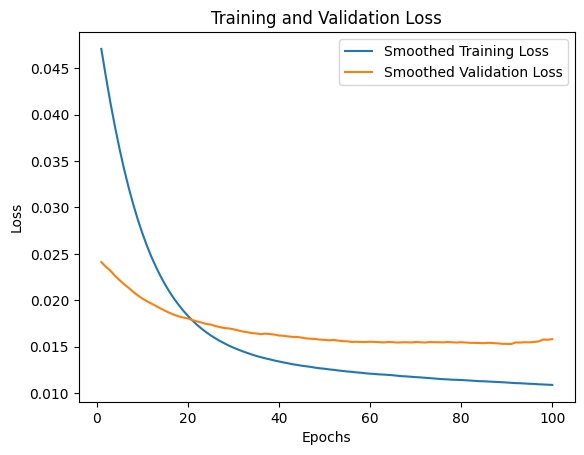

Best epoch based on validation loss: 91


In [7]:
# Retrieve loss and validation loss from history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the smoothing function
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Smooth the loss curves
smoothed_loss = smooth_curve(loss)
smoothed_val_loss = smooth_curve(val_loss)

# Plot smoothed training and validation loss
plt.plot(range(1, len(smoothed_loss) + 1), smoothed_loss, label='Smoothed Training Loss')
plt.plot(range(1, len(smoothed_val_loss) + 1), smoothed_val_loss, label='Smoothed Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Identify the epoch with the lowest validation loss
best_epoch = np.argmin(smoothed_val_loss) + 1
print(f"Best epoch based on validation loss: {best_epoch}")

In [8]:
# Refine the LSTM model
model = Sequential()
model.add(Input(shape=(SEQ_LENGTH, X_train.shape[2]))) 
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))  
model.compile(optimizer='adam', loss='mse')

print(model.summary())

# Train the model
start = time.time()
history = model.fit(X_train, y_train, epochs=best_epoch, batch_size=32, validation_split=0.2)
end = time.time()

print(f"\nTraining time: {minutes} minutes and {seconds} seconds")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 50)             │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,451 (44.73 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/91
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0711 - val_loss: 0.0195
Epoch 2/91
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - val_loss: 0.0183
Epoch 3/91
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 - val_loss: 0.0178
Epoch 4/91
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - val_loss: 0.0174
Epoch 5/91
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - val_loss: 0.0179
Epoch 6/91
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 - val_loss: 0.0169
Epoch 7/91
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - val_loss: 0.0171
Epoch 8/91
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - val_loss: 0.0168
Epoch 9/91
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - val_loss: 0.0175
Epoch 10/91
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0142 - val_loss: 0.0170
Epoch 11/91
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 - val_loss: 0.0167
Epoch 12/91
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

In [9]:

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and the actual values
predictions_inv = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_train_data.shape[1] - 1))), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_train_data.shape[1] - 1))), axis=1))[:, 0]

# Compare the first few predictions with the actual values
comparison = pd.DataFrame({'Actual': y_test_inv, 'Predicted': predictions_inv})
print(comparison.head())


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 0.1112
Test Loss: 0.09980463981628418
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
   Actual  Predicted
0    19.7  16.837419
1    15.1  17.222478
2    15.7  18.404970
3    16.0  18.723281
4    10.9  17.777026
